In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy Libraries
from scipy.io import arff
from scipy.io.arff import loadarff

# Sklearn Libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score, precision_score,
                            recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Boosting Libraries
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv1D, Dense, Dropout, Flatten, 
                                    GlobalAveragePooling1D, GlobalMaxPooling1D, LeakyReLU, MaxPooling1D, 
                                    ReLU)
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Plotting settings
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # minus 표시

# # 행 표시
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', 10)

import os
import librosa.display
import scipy.io as sio
import scipy.io.wavfile
import sounddevice as sd
from pathlib import Path
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings('ignore')


전체 파일 개수 : 348
불량품 개수 : 293
양품 개수 : 55


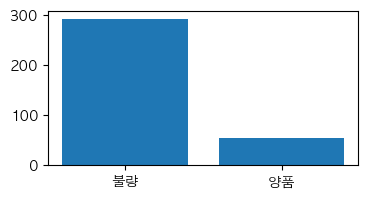

In [26]:
# 파일명 저장, 개수 확인

import glob

abnorm_files = glob.glob('/Users/park/play/data/audio/abnorm/*.wav')
normal_files = glob.glob('/Users/park/play/data/audio/normal/*.wav')

all_files = abnorm_files + normal_files
print(f'전체 파일 개수 : {len(all_files)}')
print(f'불량품 개수 : {len(abnorm_files)}')
print(f'양품 개수 : {len(normal_files)}')

plt.figure(figsize=(4,2))
plt.bar(['불량', '양품'], [len(abnorm_files), len(normal_files)])
plt.show()

In [4]:
# wave 파일에 대한 sample rate와 data 형식 확인 (2D data)
# - stereo 오디오 형식으로 처리함 (왼쪽, 오른쪽)
# - 원시 PCM 데이터를 정수형식으로 반환
# - 원래 오디오파일의 sampling rate를 반환
sample_data = normal_files[0]
sample_rate, data = sio.wavfile.read(sample_data)
print(sample_rate) # 1초당 샘플링 되는 횟수
print(data.shape)

192000
(587536, 2)


### # waveform, stft, stft_db, mfcc 하나씩 살펴보기

- waveform

---

sample rate : 192000
waveform shape : (587536,)


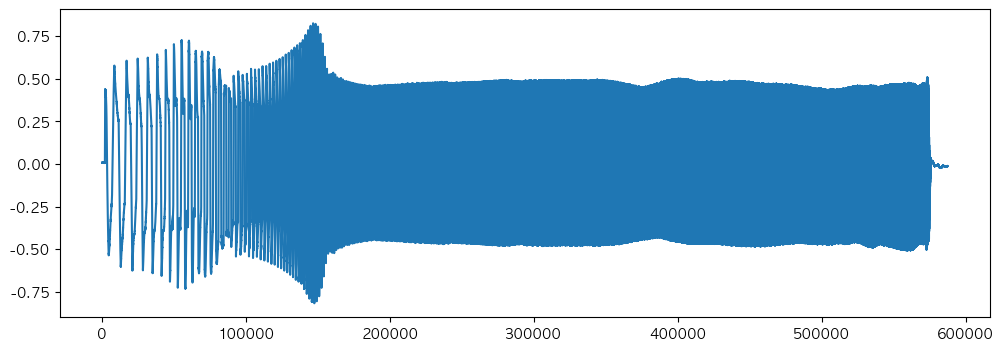

In [34]:
# waveform 파일로 변환하기 (1D data)
# - mono 오디오 형식으로 처리함 (stereo 두 채널의 평균값)
# - -1~1 사이의 값으로 반환
sample_data = normal_files[0] # 데이터 구조를 확인하기 위한 샘플 데이터
wave, sr = librosa.load(sample_data, sr=sample_rate)
print(f'sample rate : {sr}') # 1초당 샘플링 되는 횟수
print(f'waveform shape : {wave.shape}')

# waveform 시각화
# - x : sampling rate의 샘플 번호
# - y : 진폭 (주파수 아님, 주파수를 보고싶다면 stft, mfcc로 변환)
plt.figure(figsize=(12,4))
plt.plot(wave)
plt.show()

- stft

---

(1025, 1148)


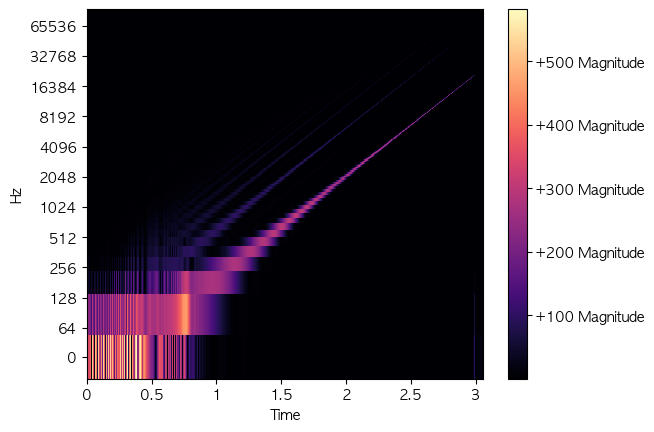

In [7]:
# stft(wavetogram)은 복소수 형태 (실수+허수)
# - 시각화를 위해서는 np.abs()처리 -> specshow() 사용 시각화
# - (1025, 1148) : 1025개의 주파수 bin, 1148개의 시간 frame
# -> stft를 구하는 목적 : 시간에 따른 주파수 성분의 변화를 분석, 시각화 하기 위함
stft = librosa.stft(wave)
print(stft.shape)
librosa.display.specshow(np.abs(stft), sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f Magnitude") # 복소수의 크기 : 진폭
plt.show()

# 인간의 청각은 주파수에 대해 로그 스케일로 반응 (주파수 차이를 절대적인 헤르츠 값보다는 상대적인 비율로 인식)
# 이러한 인간의 청각 특성을 반영하기 위해 주파수 축을 로그 스케일로 표시
# 로그 스케일에서는 낮은 주파수 대역이 더 넓게 표시되고, 높은 주파수 대역은 더 좁게 표시
# - 스펙트로그램에서 낮은 주파수 영역의 세부 사항을 더 잘 볼 수 있음

- stft_db

---

(1025, 1148)


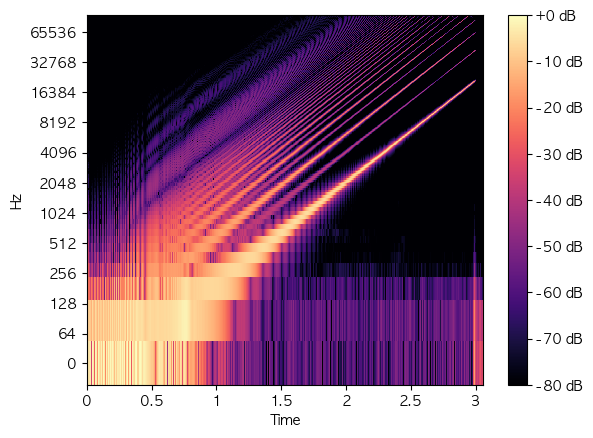

In [8]:
# librosa.amplitude_to_db() : stft의 진폭을 데시벨로 변환(스케일링)
# -> 인간의 청각 특성과 맞추기 위해

stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
print(stft_db.shape)
librosa.display.specshow(stft_db, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f dB")
plt.show()


- mfcc

---

(50, 1148)


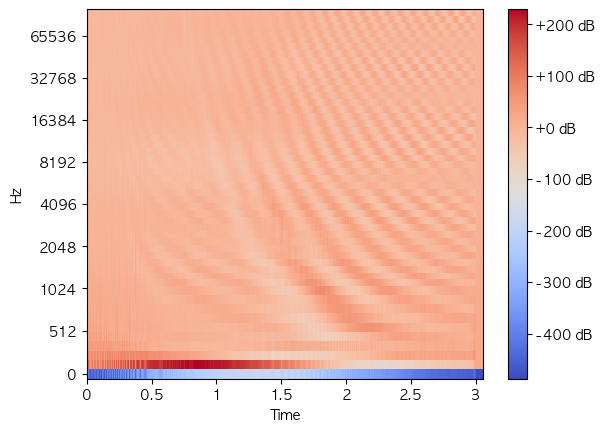

In [9]:
# MFCC는 음성 및 오디오 데이터의 복잡성을 줄이면서도 중요한 특성을 효과적으로 캡처하여,
# 다양한 오디오 처리 작업에 적합한 특징 벡터를 제공
# Mel 스케일링 : 인간의 청각 특성을 반영
# log 스케일링 : 주로 수학적 특성 또는 데이터 분포를 조정하기 위해 사용
mfcc = librosa.feature.mfcc(y=wave, sr=sample_rate, n_mfcc=50)
print(mfcc.shape)
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.show()

In [10]:
mfcc

array([[-445.18033  , -467.3564   , -478.63052  , ..., -487.41556  ,
        -482.85168  , -433.86325  ],
       [  62.97303  ,   39.06151  ,   24.464842 , ...,   13.281237 ,
          19.50992  ,   74.23526  ],
       [  39.51268  ,   32.162205 ,   21.030685 , ...,   13.200581 ,
          18.781612 ,   41.70202  ],
       ...,
       [  -3.0342848,   -4.005274 ,   -4.456941 , ...,   -5.886981 ,
          -5.368473 ,   -3.5567174],
       [  -3.2297816,   -3.9770417,   -4.452679 , ...,   -5.919116 ,
          -5.387686 ,   -3.8140802],
       [  -3.5323694,   -4.140197 ,   -4.518805 , ...,   -5.935129 ,
          -5.3844543,   -4.204494 ]], dtype=float32)

### # waveform, stft, stft_db, mfcc 전체파일 리스트 만들기
### # 라벨 리스트 만들기

In [32]:
# 모든 파일 리스트 정렬
all_files.sort()
all_files

['/Users/park/play/data/audio/abnorm/abnorm_1.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_10.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_100.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_101.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_102.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_103.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_104.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_105.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_106.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_107.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_108.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_109.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_11.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_110.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_111.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_112.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_113.wav',
 '/Users/park/play/data/audio/abnorm/abnorm_114.wav',
 '/Users/park/play/data/audio/ab

In [33]:
# 라벨 리스트 만들기
label_0 = np.array([0]*len(abnorm_files))
label_1 = np.array([1]*len(normal_files))
label = np.append(label_0, label_1)

In [12]:
# wave_list 만들기
wave_list = []
for file in all_files:
    wave, sr = librosa.load(file, sr=sample_rate)
    wave_list.append(wave)

wave_list = np.array(wave_list)
print(wave_list.shape)

(348, 587536)


In [13]:
# stft_list, db_list 만들기
stft_list = []
db_list = []

for file in all_files:
    wave, sr = librosa.load(file, sr=sample_rate)
    stft = librosa.stft(wave)
    stft_list.append(stft)
    stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    db_list.append(stft_db)
    
stft_list = np.array(stft_list)
db_list = np.array(db_list)
print(stft_list.shape)
print(db_list.shape)

(348, 1025, 1148)
(348, 1025, 1148)


In [14]:
# mfcc_list 만들기
mfcc_list = []

for file in all_files:
    wave, sr = librosa.load(file, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=wave, sr=sample_rate, n_mfcc=50)
    mfcc_list.append(mfcc)

mfcc_list = np.array(mfcc_list)
print(mfcc_list.shape)

(348, 50, 1148)


In [15]:
mfcc_list.shape

(348, 50, 1148)

In [16]:
# 전체 파일을 불러와서 wavetogram, stft, stft_db, mfcc 4가지 형태의 리스트로 저장하기
# 매칭되는 라벨 리스트 만들기

# train, test dataset 구분하기

# LSTM으로 4가지 데이터셋 모두 학습 해보기(waveform, mfcc, stft, stft_db)

# waveform(y) - 1D : 머신러닝, dnn, cnn으로 학습 -> 데이터가 커서 머신러닝은 안될 수도...
# mfcc, stft, stft_db - 2D : cnn으로 학습

In [17]:
# X = mfcc_list
# X = db_list
# X = stft_list
X = wave_list
y = label

print(f'X.shape : {X.shape}')
print(f'y.shape : {y.shape}')
print(f'클래스 0, 1 : {np.bincount(y)}')
print(f'클래스 1 비중 : {np.bincount(y)[1] / np.bincount(y)[0]:.2f}\n')

# 7:3 비율로 학습 및 테스트 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)
print(f'X_train.shape : {X_train.shape}')
print(f'y_train.sahpe : {y_train.shape}')
print(f'train 클래스 0, 1 : {np.bincount(y_train)}')
print(f'train 클래스 1 비중 : {np.bincount(y_train)[1] / np.bincount(y_train)[0]:.2f}\n')
print(f'X_val.shape : {X_val.shape}')
print(f'y_val.sahpe : {y_val.shape}')
print(f'val 클래스 0, 1 : {np.bincount(y_val)}')
print(f'val 클래스 1 비중 : {np.bincount(y_val)[1] / np.bincount(y_val)[0]:.2f}\n')
print(f'X_test.shape : {X_test.shape}')
print(f'y_test.sahpe : {y_test.shape}')
print(f'test 클래스 0, 1 : {np.bincount(y_test)}')
print(f'test 클래스 1 비중 : {np.bincount(y_test)[1] / np.bincount(y_test)[0]:.2f}\n')

X.shape : (348, 587536)
y.shape : (348,)
클래스 0, 1 : [293  55]
클래스 1 비중 : 0.19

X_train.shape : (182, 587536)
y_train.sahpe : (182,)
train 클래스 0, 1 : [153  29]
train 클래스 1 비중 : 0.19

X_val.shape : (79, 587536)
y_val.sahpe : (79,)
val 클래스 0, 1 : [67 12]
val 클래스 1 비중 : 0.18

X_test.shape : (87, 587536)
y_test.sahpe : (87,)
test 클래스 0, 1 : [73 14]
test 클래스 1 비중 : 0.19



In [18]:
# 데이터 스케일링

print(X.shape)
samples, features, times = X.shape

X_trans = X.reshape(samples, -1)
print(X_trans.shape)

scaler = StandardScaler()
X_scaled_trans = scaler.fit_transform(X_trans)
print(X_scaled_trans.shape)

X_scaled = X_scaled_trans.reshape(samples, features, times)
print(X_scaled.shape)


(348, 587536)


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
db_list

array([[[-41.08755 , -36.230713, -35.58477 , ..., -31.723099,
         -32.353077, -35.081417],
        [-42.888123, -40.78646 , -42.084015, ..., -37.537453,
         -38.273575, -38.30304 ],
        [-48.290535, -56.770256, -74.86034 , ..., -68.65352 ,
         -68.178215, -48.739326],
        ...,
        [-80.      , -80.      , -80.      , ..., -80.      ,
         -80.      , -80.      ],
        [-80.      , -80.      , -80.      , ..., -80.      ,
         -80.      , -80.      ],
        [-80.      , -80.      , -80.      , ..., -80.      ,
         -80.      , -80.      ]],

       [[-40.263885, -35.45335 , -35.34259 , ..., -30.723331,
         -31.055107, -34.050766],
        [-42.064884, -39.80276 , -41.657257, ..., -36.644264,
         -36.57273 , -37.20629 ],
        [-47.52978 , -55.43213 , -65.64431 , ..., -75.97872 ,
         -69.43534 , -48.154724],
        ...,
        [-80.      , -80.      , -80.      , ..., -80.      ,
         -80.      , -80.      ],
        [-80

In [ ]:
db_list_scaled

array([[[ 0.0401208 ,  0.00686672,  0.02864704, ...,  0.07985234,
         -0.58927786, -0.6849536 ],
        [ 0.04356047, -0.01654088, -0.01599476, ...,  0.05887012,
         -1.3031318 , -0.78731644],
        [ 0.06970647,  0.07925066, -1.2332873 , ..., -1.0577621 ,
         -0.9905511 , -0.32480198],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.22997227,  0.18254326,  0.07849821, ...,  0.6677482 ,
          0.36164945,  0.19387452],
        [ 0.2335785 ,  0.20891169,  0.07517573, ...,  0.78756315,
          0.30093163,  0.18167771],
        [ 0.24657036,  0.40402502,  1.142342  , ..., -2.4678488 ,
         -1.2543634 ,  0.11895659],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
            metrics=['sparse_categorical_accuracy'])


In [ ]:
348/32

10.875

In [ ]:
# LSTM 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.3)

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/10
11/11 [==============================] - 2s 80ms/step - loss: 0.4451 - sparse_categorical_accuracy: 0.8471 - val_loss: 0.4560 - val_sparse_categorical_accuracy: 0.8219
Epoch 2/10
11/11 [==============================] - 1s 53ms/step - loss: 0.4093 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.4485 - val_sparse_categorical_accuracy: 0.8219
Epoch 3/10
11/11 [==============================] - 1s 56ms/step - loss: 0.4079 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.4537 - val_sparse_categorical_accuracy: 0.8219
Epoch 4/10
11/11 [==============================] - 1s 55ms/step - loss: 0.4104 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.4499 - val_sparse_categorical_accuracy: 0.8219
Epoch 5/10
11/11 [==============================] - 1s 56ms/step - loss: 0.4069 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.4881 - val_sparse_categorical_accuracy: 0.8219
Epoch 6/10
11/11 [==============================] - 1s 63ms/step - loss: 0.4524 - sparse_categorical_accu

In [ ]:
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 dropout (Dropout)           (None, 1025, 1148)        0         
                                                                 
 lstm (LSTM)                 (None, 1025, 16)          74560     
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
=================================================================
Total params: 80898 (316.01 KB)
Trainable params: 80898 (316.01 KB)
Non-trainable params: 0 (0.00 Byte)

In [ ]:
74560-16
1025*16

16400

In [ ]:
((1148*64) + 64 + (64*64)) * 4

310528

In [ ]:
((64*16) + 16 + (16*16)) * 4

5184

In [ ]:
(16*2) + 2

34

In [ ]:
# CNN 학습을 위해 데이터 shape 변환
X_train_exp = np.expand_dims(X_train, -1) # X_train 배열의 마지막 차원에 새로운 축을 추가
X_test_exp = np.expand_dims(X_test, -1) # X_test 배열의 마지막 차원에 새로운 축을 추가

Epoch 1/10


2023-09-19 13:03:15.595084: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


12/12 [==============================] - 9s 638ms/step - loss: 1.0131 - sparse_categorical_accuracy: 0.4560 - val_loss: 0.6795 - val_sparse_categorical_accuracy: 0.9620
Epoch 2/10
12/12 [==============================] - 8s 615ms/step - loss: 0.6975 - sparse_categorical_accuracy: 0.5714 - val_loss: 0.6949 - val_sparse_categorical_accuracy: 0.9494
Epoch 3/10
12/12 [==============================] - 9s 719ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.7418 - val_loss: 0.6374 - val_sparse_categorical_accuracy: 0.8481
Epoch 4/10
12/12 [==============================] - 8s 614ms/step - loss: 0.6493 - sparse_categorical_accuracy: 0.7253 - val_loss: 0.6205 - val_sparse_categorical_accuracy: 0.8481
Epoch 5/10
12/12 [==============================] - 10s 821ms/step - loss: 0.5139 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.6130 - val_sparse_categorical_accuracy: 0.8481
Epoch 6/10
12/12 [==============================] - 8s 656ms/step - loss: 0.5138 - sparse_categorical_accuracy

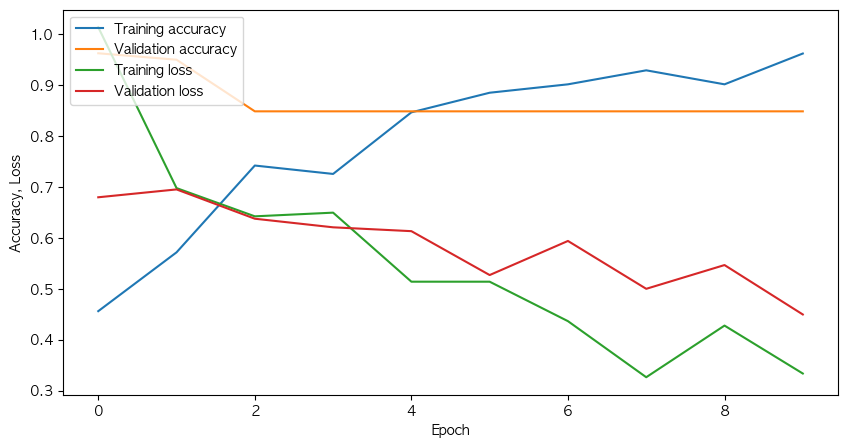

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 587536, 8)         32        
                                                                 
 batch_normalization (BatchN  (None, 587536, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4590, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 36720)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 36720)            146880    
 hNormalization)                                                 
                                                        

In [ ]:
## CNN 학습 및 예측 결과
# 하이퍼파라미터 설정
epoch = 5 # 학습 반복 횟수
input_dim = X_train.shape[1]
act = 'LeakyReLU' # 활성화 함수
opt = 'adam' # optimizer
filters = 8 # Conv1D Layer의 filter수
batch = 16 # batch size
kernel = 3 # filter의 kernel size
drops = 0.2 # drop 비율

# 모델 정의(구조)

def make_cnn_model():
    model = Sequential()
    # Conv1D Layer
    model.add(Conv1D(filters=filters, kernel_size=kernel, activation=act,
                    padding='same', input_shape=(input_dim, 1)))
    model.add(BatchNormalization()) # batch 데이터의 분포를 정규화
    model.add(MaxPooling1D(pool_size=128))  # MaxPooling1D Layer

    # Flatten Layer
    model.add(Flatten()) # filter에 의해 만들어진 다차원의 데이터를 1차원으로 변환
    model.add(BatchNormalization()) # batch 데이터의 분포를 정규화
    model.add(Dropout(drops)) 

    # Dense Layer
    model.add(Dense(8, activation=act)) # Dens Layer 노드 수, 활성함수 설정
    model.add(BatchNormalization())# batch 데이터의 분포를 정규화
    model.add(Dropout(drops)) # 과적합 방지를 위한 drop

    # # Dense Layer
    # model.add(Dense(8, activation=act)) # Dens Layer 노드 수, 활성함수 설정
    # model.add(BatchNormalization())# batch 데이터의 분포를 정규화
    # model.add(Dropout(drops)) # 과적합 방지를 위한 drop

    # Output Layer
    model.add(Dense(2, activation='softmax')) # 2개 클래스의 확률을 출력

    return model

cnn_model = make_cnn_model() # 모델 초기화

# 모델 컴파일
cnn_model.compile(optimizer=opt, # optimizer: 학습 최적화 알고리즘
                loss='sparse_categorical_crossentropy', # 사용할 손실 함수
                metrics=['sparse_categorical_accuracy']) # 모델의 평가 지표

# monitor 지표를 기준으로 베스트 모델을 저장
callbacks = [ModelCheckpoint('best_model.h5', save_best_only=True,
            monitor='val_sparse_categorical_accuracy', mode='max')]

history = cnn_model.fit(X_train_exp, y_train, # 학습데이터, 라벨
                        batch_size=batch, # batch 크기 지정
                        validation_data=(X_val, y_val), # 검증용 데이터의 비율 지정
                        epochs=epoch, # 학습 반복 횟수
                        callbacks=callbacks) # 검증 정확도가 올라갈때만 모델 저장

# 훈련/검증 정확도 최대값과 해당 인덱스를 변수에 할당
maX_train_accuracy = max(history.history['sparse_categorical_accuracy'])
max_val_accuracy = max(history.history['val_sparse_categorical_accuracy'])
max_tra_acc_idx = np.argmax(history.history['sparse_categorical_accuracy']) + 1
max_val_acc_idx = np.argmax(history.history['val_sparse_categorical_accuracy']) + 1

# 훈련/검증 loss 최소값과 해당 인덱스를 변수에 할당
min_train_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])
min_tra_loss_idx = np.argmin(history.history['loss']) + 1
min_val_loss_idx = np.argmin(history.history['val_loss']) + 1

# 훈련/검증 정확도 최대값과 해당 인덱스 출력, loss 최소값과 해당 인덱스 출력
print(f'Max train acc : {max_tra_acc_idx}_epoch_{maX_train_accuracy}')
print(f'Max val acc: {max_val_acc_idx}_epoch_{max_val_accuracy}')
print(f'Min train loss : {min_tra_loss_idx}_epoch_{min_train_loss}')
print(f'Min val loss: {min_val_loss_idx}_epoch_{min_val_loss}')

#  베스트 모델로 test dataset 평가 (베스트 모델은 callbacks에 설정 됨)
model = load_model('best_model.h5')
loss_cnn, acc_cnn = model.evaluate(X_test_exp, y_test)
print('test acc ', acc_cnn) # 정확도 출력
print('test loss ', loss_cnn) # loss 출력

# 클래스별 예측 확률, 예측 값
probs = model.predict(X_test_exp)[:, 1] # 예측 결과가 클래스 1에 속할 확률
y_pred = np.argmax(model.predict(X_test_exp), axis=1) # 예측 값

# 평가지표 계산
accuracy = accuracy_score(y_test, y_pred) # 정확도 (acc_cnn 과 동일함)
precision = precision_score(y_test, y_pred) # 정밀도: 양성이라고 예측한것중 실제 양성의 비율
recall = recall_score(y_test, y_pred) # 재현율(민감도): 실제 양성 중 양성으로 예측된 비율
f1 = f1_score(y_test, y_pred) # f1: 2 * (정밀도*재현율)/(정밀도+재현율)
auc_score = roc_auc_score(y_test, probs)  # AUC 계산 (ROC 곡선 아래의 면적)

# 평가지표 출력
print(f"Metrics")
print(f" - Accuracy: {round(accuracy*100,2)}%")
print(f" - Precision: {round(precision*100,2)}%")
print(f" - Recall: {round(recall*100,2)}%")
print(f" - F1 Score: {round(f1*100,2)}%")
print(f" - AUC: {round(auc_score*100,2)}%")

## 학습데이터, 검증데이터의 정확도, loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(history.history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel('Accuracy, Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# 모델 구조 / 파라미터 개수 확인
model.summary()
